In [2]:
import torch
import numpy as np
import os

In [3]:
from embedder import make 
from decoder import make_decoder

In [4]:
e = make.make_embedder()
d = make_decoder.make_decoder()

/home/kunal/miniconda3/envs/UKB/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from model import Model
test = Model(embedder=e,decoder=d,encoder="/home/kunal/UKB/Neuro_GPT/NeuroGPT_UKB/Neuro-GPT/pretrained_model/pytorch_model.bin")

In [31]:
def create_dummy_eeg_input(batch_size=1, num_chunks=32):
    # EEG dimensions based on paper
    channels = 22
    timepoints = 500  # 2 seconds * 250 Hz
    
    # Create random EEG-like data
    dummy_input = torch.randn(batch_size, num_chunks, channels, timepoints)
    attention_mask = torch.ones(batch_size, num_chunks, dtype=torch.long)
    
    # Labels not needed for encoder-only output
    batch = {
        'inputs': dummy_input,
        'attention_mask': attention_mask,
    }
    return batch

In [23]:
test

Model(
  (embedder): CSMEmbedder(
    (xe_loss): CrossEntropyLoss()
    (bxe_loss): BCEWithLogitsLoss()
    (l1_loss): L1Loss()
    (l2_loss): MSELoss()
    (embed_model): EmbeddingModel(
      (model): Sequential(
        (0): Linear(in_features=1024, out_features=768, bias=True)
        (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): GPTModel(
    (mse_loss): MSELoss()
    (bxe_loss): BCEWithLogitsLoss()
    (transformer): GPT2Model(
      (wte): Embedding(1, 768)
      (wpe): Embedding(512, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-3): 4 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): 

### Novel approach based on insights gained from NeuroGPT/src/encoder/conformer_braindecode.py

I paid attention to the [NeuroGPT paper](https://arxiv.org/pdf/2311.03764) where they describe the EEG Encoder:

EEG Encoder We adopt an encoder architecture incorporating
both convolutional and self-attention modules. This
arrangement has achieved state-of-the-art performance in
BCI classification tasks [13]. We split the raw EEG signals
into N chunks, each of time length T. This results in a sequence
of chunks denoted {D1,D2, · · · ,DN}. Each chunk
is of dimension C × T, where C is the number of channels.
Each chunk is treated as an individual training sample in the
encoder. In the **convolutional module** , we apply a temporal
convolution filter to the time series and a spatial convolution
filter to the electrodes of the EEG **(this corresponds to the _PatchEmbedding Class
that is part of the EEGConformer class imported below)**. Then after average pooling **(still part of _PatchEmbedding)**,
the extracted local features are fed into the self-attention
layers to incorporate temporal dependencies within a chunk.
The self-attention mechanism combined with convolution
will encode the spatio-temporal features of each chunk. The
outputs of the encoder are the embedded chunks or tokens.

**Below in the paper we can infer the output size:**
A linear layer is added before the GPT-2 model to
project the embedding dimension from 1080 to 1024.

In [32]:
from encoder.conformer_braindecode import EEGConformer # from NeuroGPT/src/encoder/conformer_braindecode.py

This was my first try and not correct yet:

In [15]:
# 1st try: only obtaining the output of the patch embedding (convolution layers) and potentially with wrong parameters
def create_eeg_input(batch_size=1):
    N_CHUNKS = 32  # From paper pretraining
    N_CHANNELS = 22 
    SAMPLES_PER_CHUNK = 500  # 2s * 250Hz sampling rate

    x = torch.randn(batch_size, N_CHUNKS, N_CHANNELS, SAMPLES_PER_CHUNK)
    attention_mask = torch.ones(batch_size, N_CHUNKS, dtype=torch.long)

    return x, attention_mask

def get_embeddings(pretrained_path):
    N_CHUNKS = 32  # From paper pretraining
    N_CHANNELS = 22
    SAMPLES_PER_CHUNK = 500
    N_FILTERS = 40
    FILTER_LENGTH = 25
    POOL_LENGTH = 75
    POOL_STRIDE = 15

    encoder = EEGConformer(
       n_chans=N_CHANNELS,
       n_times=SAMPLES_PER_CHUNK,
       n_filters_time=N_FILTERS,
       filter_time_length=FILTER_LENGTH,
       pool_time_length=POOL_LENGTH,
       pool_time_stride=POOL_STRIDE
    )

    pretrained = torch.load(pretrained_path, map_location=torch.device('cpu'))
    encoder.load_state_dict({k.replace('encoder.',''):v for k,v in pretrained.items() if k.startswith('encoder.')})
    encoder.eval()

    x, mask = create_eeg_input()
    with torch.no_grad():
        batch_size = x.size(0)
        x = x.contiguous().view(-1, N_CHANNELS, SAMPLES_PER_CHUNK)
        x = torch.unsqueeze(x, dim=1)
        embeddings = encoder.patch_embedding(x)
        #embeddings = embeddings.reshape(batch_size*N_CHUNKS, -1)
    return embeddings

In [16]:
get_embeddings("c://Neuro-GPT//pretrained_model//pytorch_model.bin").shape

torch.Size([32, 27, 40])

This will probably do the trick or will be close:

In [17]:
# second try: hopefully correct NeuroGPT architecture,this time including the self-attention 
# transformer layers to get the final embeddings that would be fed into GPT-2.
def create_eeg_input(batch_size=1):
    """Create input EEG data matching NeuroGPT pretraining specs"""
    N_CHUNKS = 32  # paper pretraining: 32 chunks
    N_CHANNELS = 22  # paper: 22-channel EEG
    SAMPLES_PER_CHUNK = 500  # 2s * 250Hz sampling rate

    x = torch.randn(batch_size, N_CHUNKS, N_CHANNELS, SAMPLES_PER_CHUNK)
    attention_mask = torch.ones(batch_size, N_CHUNKS, dtype=torch.long)

    return x, attention_mask

def get_neurogpt_embeddings(pretrained_path, device='cpu'):
    """Get embeddings using pretrained NeuroGPT encoder"""
    # Initialize encoder with paper specifications
    encoder = EEGConformer(
       n_chans=22,
       n_times=500,
       n_filters_time=40,
       filter_time_length=25,
       pool_time_length=75,
       pool_time_stride=15,
       att_depth=6, 
       att_heads=10,
       att_drop_prob=0.5,
       is_decoding_mode=False
    )

    # Load and inspect pretrained weights
    pretrained = torch.load(pretrained_path, map_location=torch.device(device))

    print("Available keys in pretrained weights:")
    for k in pretrained.keys():
        print(k)

    # Load weights 
    encoder_state_dict = {k.replace('encoder.',''):v for k,v in pretrained.items() 
                        if k.startswith('encoder.')}

    encoder.load_state_dict(encoder_state_dict)

    print("\nLoaded state dict keys:")
    for k in encoder.state_dict().keys():
        print(k)

    encoder.eval()

    # Create input data
    x, mask = create_eeg_input()
    x = x.to(device)

    with torch.no_grad():
       # Process through encoder
        batch, chunks, chann, time = x.size()
        x = x.contiguous().view(batch*chunks, chann, time)
        x = torch.unsqueeze(x, dim=1)

        # Get embeddings through full encoder path
        x = encoder.patch_embedding(x)  # Convolutional layers 
        embeddings = encoder.transformer(x)  # Self-attention layers

    return embeddings



# Get embeddings and print info
embeddings = get_neurogpt_embeddings("c://Neuro-GPT//pretrained_model//pytorch_model.bin")
print(f"\nEmbeddings shape: {embeddings.shape}")

Available keys in pretrained weights:
encoder.patch_embedding.shallownet.0.weight
encoder.patch_embedding.shallownet.0.bias
encoder.patch_embedding.shallownet.1.weight
encoder.patch_embedding.shallownet.1.bias
encoder.patch_embedding.shallownet.2.weight
encoder.patch_embedding.shallownet.2.bias
encoder.patch_embedding.shallownet.2.running_mean
encoder.patch_embedding.shallownet.2.running_var
encoder.patch_embedding.shallownet.2.num_batches_tracked
encoder.patch_embedding.projection.0.weight
encoder.patch_embedding.projection.0.bias
encoder.transformer.0.0.fn.0.weight
encoder.transformer.0.0.fn.0.bias
encoder.transformer.0.0.fn.1.keys.weight
encoder.transformer.0.0.fn.1.keys.bias
encoder.transformer.0.0.fn.1.queries.weight
encoder.transformer.0.0.fn.1.queries.bias
encoder.transformer.0.0.fn.1.values.weight
encoder.transformer.0.0.fn.1.values.bias
encoder.transformer.0.0.fn.1.projection.weight
encoder.transformer.0.0.fn.1.projection.bias
encoder.transformer.0.1.fn.0.weight
encoder.transf

The shape we're getting is [32, 27, 40] which means:

32 chunks
27 sequence length (from pooling: (500 - 75)/15 + 1 = 27)
40 features (n_filters_time)


27 * 40 => 1080


This is exactly what is mentioned in the paper \
"A linear layer is added before the GPT-2 model to
project the embedding dimension from 1080 to 1024." \

For us, at first it does not really matter whether we use an embedding of 1080 or 1024 dimensions as embeddings for classification ... 

For inputting EEG data you will have to modify create_eeg_input. \
Please study [this code](https://github.com/wenhui0206/NeuroGPT/blob/230571d45ca4369b82f33ab42fc00863c2f95598/src/encoder/conformer_braindecode.py) carefully. \
In theory, even a classification module is in it that I didnt use (we could also use SVMs or other simple nets)

[This function](https://github.com/wenhui0206/NeuroGPT/blob/230571d45ca4369b82f33ab42fc00863c2f95598/src/train_gpt.py) gives a nice high level overview of the codebase.In it you find code like this: 


from batcher.base import EEGDataset
        validation_dataset = EEGDataset(files[:1000], sample_keys=[
            'inputs',
            'attention_mask'
        ], chunk_len=config["chunk_len"], num_chunks=config["num_chunks"], ovlp=config["chunk_ovlp"], root_path=root_path, gpt_only= not config["use_encoder"], normalization=config["do_normalization"])


# NeuroGPT EEG Processing Functions

Edf file is loaded from [here](https://physionet.org/content/chbmit/1.0.0/chb12/) as input.

## Core Functions

### 1. Split Chunks Function
```python
def split_chunks_all(data, chunk_length=500, overlap=50, num_chunks=32, max_batches=None)
```
Creates multiple batches of 32 overlapping chunks from continuous EEG data.

**Parameters:**
- `data`: EEG data array [channels, time_points]
- `chunk_length`: Length of each chunk (500 samples = 2s at 250Hz)
- `overlap`: Overlap between chunks (50 samples = 0.2s)
- `num_chunks`: Number of chunks per batch (fixed at 32 as in paper)
- `max_batches`: Optional limit on number of batches 

**Output:** Array of shape [n_batches, 32, channels, chunk_length]

### 2. Preprocessing Function
```python
def preprocess_eeg_neurogpt(edf_path, max_batches=None)
```
Loads and preprocesses EEG data according to NeuroGPT specifications.

**Steps:**
1. Loads EDF file
2. Resamples to 250Hz
3. Maps to standard 22-channel montage
4. Applies 0.5-100Hz bandpass filter (as specified in paper)
5. Normalizes data
6. Generates batches of 32 chunks using split_chunks_all

**Output:** Dictionary containing:
- 'inputs': Tensor [n_batches, 32, 22, 500]
- 'attention_mask': Tensor [n_batches, 32]

### 3. Embedding Function
```python
def get_neurogpt_embeddings(pretrained_path, batch, device='cpu')
```
Processes EEG data through pretrained encoder.

**Steps:**
1. Loads pretrained weights
2. Processes through convolutional layers
3. Processes through transformer layers
4. Reshapes to [n_batches*32, 1080]

**Output:** Embeddings tensor [n_batches*32, 1080]

## Pipeline Overview

1. **Data Loading & Preprocessing:**
   - Raw EEG → Preprocessing → Multiple batches of 32 chunks
   - Each chunk is 2 seconds with 0.2s overlap
   - Each batch contains exactly 32 chunks as required by the paper

2. **Encoder Processing:**
   - Load pretrained encoder
   - Process all batches through encoder
   - Generate 1080-dimensional embeddings per chunk

3. **Output:**
   - Final embeddings ready for GPT-2 input
   - Each embedding represents 2s of EEG data
   - 32 chunks per batch maintain temporal continuity through overlapping
   - Multiple batches can be generated from long recordings

The pipeline processes entire EEG recordings while maintaining temporal relationships through overlapping chunks and structured batching into sets of 32 chunks each.

In [6]:
import mne
import numpy as np
import torch
def get_neurogpt_embeddings(pretrained_path, batch, device='cpu'):
    """Get embeddings using pretrained NeuroGPT encoder"""
    # Initialize encoder
    encoder = EEGConformer(
        n_chans=22,
        n_times=500,
        n_filters_time=40,
        filter_time_length=25,
        pool_time_length=75,
        pool_time_stride=15,
        att_depth=6,
        att_heads=10,
        att_drop_prob=0.5,
        is_decoding_mode=False
    )
    
    # Load weights
    device = torch.device(device)
    pretrained = torch.load(pretrained_path, map_location=device)
    encoder_state_dict = {k.replace('encoder.',''):v for k,v in pretrained.items() 
                         if k.startswith('encoder.')}
    encoder.load_state_dict(encoder_state_dict)
    encoder.eval()
    encoder.to(device)
    
    with torch.no_grad():
        x = batch['inputs'].to(device)
        print("Input tensor shape:", x.shape)
        
        # Handle different input shapes
        if len(x.shape) == 3:  # [chunks, channels, time]
            chunks, chann, time = x.shape
            batch_size = 1
        else:  # [batch, chunks, channels, time]
            batch_size, chunks, chann, time = x.shape
            
        x = x.view(-1, chann, time)  # Combine batch and chunks if present
        x = torch.unsqueeze(x, dim=1)  # Add channel dim for Conv2d
        
        x = encoder.patch_embedding(x)
        x = encoder.transformer(x)


def split_chunks_all(data, chunk_length=500, overlap=50, num_chunks=32, max_batches=None):
    """
    Split EEG data into batches of overlapping chunks with optional limit
    """
    _, total_len = data.shape
    batch_length = chunk_length * num_chunks - overlap * (num_chunks - 1)
    stride = chunk_length - overlap

    # Calculate number of possible batches
    n_possible_batches = (total_len - batch_length) // stride + 1

    if max_batches is not None:
        n_batches = min(n_possible_batches, max_batches)
    else:
        n_batches = n_possible_batches

    print(f"Creating {n_batches} batches of {num_chunks} chunks each")

    all_batches = []
    for batch_idx in range(n_batches):
        batch_start = batch_idx * stride
        chunks = []
        chunk_start = batch_start

        for i in range(num_chunks):
            chunk = data[:, chunk_start:chunk_start + chunk_length]
            chunks.append(chunk)
            chunk_start += chunk_length - overlap

        all_batches.append(np.stack(chunks))

    return np.stack(all_batches)  # Shape: [n_batches, num_chunks, channels, chunk_length]

def preprocess_eeg_neurogpt(edf_path, max_batches=None):
    """Process EDF file according to NeuroGPT paper specs"""
    # Load EDF
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    print("Original channels:", raw.ch_names)

    # CHB-MIT to standard mapping
    chb_to_standard = {
        'FP1-F7': 'FP1', 'F7-T7': 'F7', 'T7-P7': 'T3', 'P7-O1': 'T5',
        'FP1-F3': 'F3', 'F3-C3': 'C3', 'C3-P3': 'P3', 
        'FP2-F4': 'F4', 'F4-C4': 'C4', 'C4-P4': 'P4',
        'FP2-F8': 'FP2', 'F8-T8': 'F8', 'T8-P8-0': 'T4',
        'T8-P8-1': 'T6', 'FZ-CZ': 'FZ', 'CZ-PZ': 'CZ'
    }

    # Only rename existing channels
    existing_channels = {k: v for k, v in chb_to_standard.items() if k in raw.ch_names}
    raw.rename_channels(existing_channels)

    # Downsample to 250Hz if needed
    if raw.info['sfreq'] != 250:
        raw.resample(250)

    # Filter
    raw.filter(l_freq=.5, h_freq=100)
    data = raw.get_data()
    print("Data shape after loading:", data.shape)

    # Define target standard channels
    standard_channels = [
        'FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 
        'T1', 'T3', 'C3', 'CZ', 'C4', 'T4', 'T2',
        'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'OZ', 'O2'
    ]

    # Create full data array
    full_data = np.zeros((len(standard_channels), data.shape[1]))
    for idx, ch in enumerate(standard_channels):
        if ch in raw.ch_names:
            ch_idx = raw.ch_names.index(ch)
            full_data[idx] = data[ch_idx]

    # Normalize
    full_data = (full_data - np.mean(full_data, axis=1, keepdims=True)) / (np.std(full_data, axis=1, keepdims=True) + 1e-6)

    # Get all batches of chunks
    batches = split_chunks_all(full_data, max_batches=max_batches)

    return {
    'inputs': torch.from_numpy(batches).float(),  # Shape: [n_batches, 32, 22, 500]
    'attention_mask': torch.ones(batches.shape[0], batches.shape[1], dtype=torch.long)  # Shape: [n_batches, 32]
    }

def get_neurogpt_embeddings(pretrained_path, batch, device='cpu'):
    """Get embeddings using pretrained NeuroGPT encoder"""
    encoder = EEGConformer(
       n_chans=22,
       n_times=500,
       n_filters_time=40,
       filter_time_length=25,
       pool_time_length=75,
       pool_time_stride=15,
       att_depth=6,
       att_heads=10,
       att_drop_prob=0.5,
       is_decoding_mode=False
    )

    device = torch.device(device)
    pretrained = torch.load(pretrained_path, map_location=device)
    encoder_state_dict = {k.replace('encoder.',''):v for k,v in pretrained.items() 
                        if k.startswith('encoder.')}
    encoder.load_state_dict(encoder_state_dict)
    encoder.eval()
    encoder.to(device)

    with torch.no_grad():
        x = batch['inputs'].to(device)
        print("Input tensor shape:", x.shape)

        n_batches = x.shape[0] if len(x.shape) == 4 else 1
        chunks = 32
        chann = 22
        time = 500

        x = x.reshape(-1, chann, time)  # Combine batches and chunks
        x = torch.unsqueeze(x, dim=1)  # Add channel dim for Conv2d

        x = encoder.patch_embedding(x)
        x = encoder.transformer(x)
        embeddings = x.reshape(n_batches*chunks, -1)  # [n_batches*32, 1080]

        print("Embeddings shape:", embeddings.shape)
        return embeddings

# Usage:
if __name__ == "__main__":
    edf_path = "/home/kunal/UKB/Neuro_GPT/NeuroGPT_UKB/data/chb12_06.edf"
    processed_data = preprocess_eeg_neurogpt(edf_path, max_batches=10)  # Limit to 10 batches
    print("\nProcessed data shapes:")
    print("Inputs:", processed_data['inputs'].shape)
    print("Attention mask:", processed_data['attention_mask'].shape)

    weights_path = "/home/kunal/UKB/Neuro_GPT/NeuroGPT_UKB/Neuro-GPT/pretrained_model/pytorch_model.bin"
    embeddings = get_neurogpt_embeddings(weights_path, processed_data)

Extracting EDF parameters from /home/kunal/UKB/Neuro_GPT/NeuroGPT_UKB/data/chb12_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 923135  =      0.000 ...  3605.996 secs...


/tmp/ipykernel_134700/4091066359.py:83: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
/tmp/ipykernel_134700/4091066359.py:83: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Original channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '--0', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '--1', 'FZ-CZ', 'CZ-PZ', '--2', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '--3', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', '--4', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Data shape after loading: (28, 901500)
Creating 10 batches of 32 chunks each

Processed data shapes:
Inputs: torch.Size([10, 32, 22, 500])
Attention mask: torch.Size([10, 32])


NameError: name 'EEGConformer' is not defined

In [21]:
processed_data['inputs'].shape

torch.Size([10, 32, 22, 500])

In [38]:
embeddings.shape

torch.Size([320, 1080])

--------------
Data shape before processing: (22, 128728)
--------------
Creating RawArray with float64 data, n_channels=22, n_times=128728
    Range : 0 ... 128727 =      0.000 ...   502.840 secs
Ready.


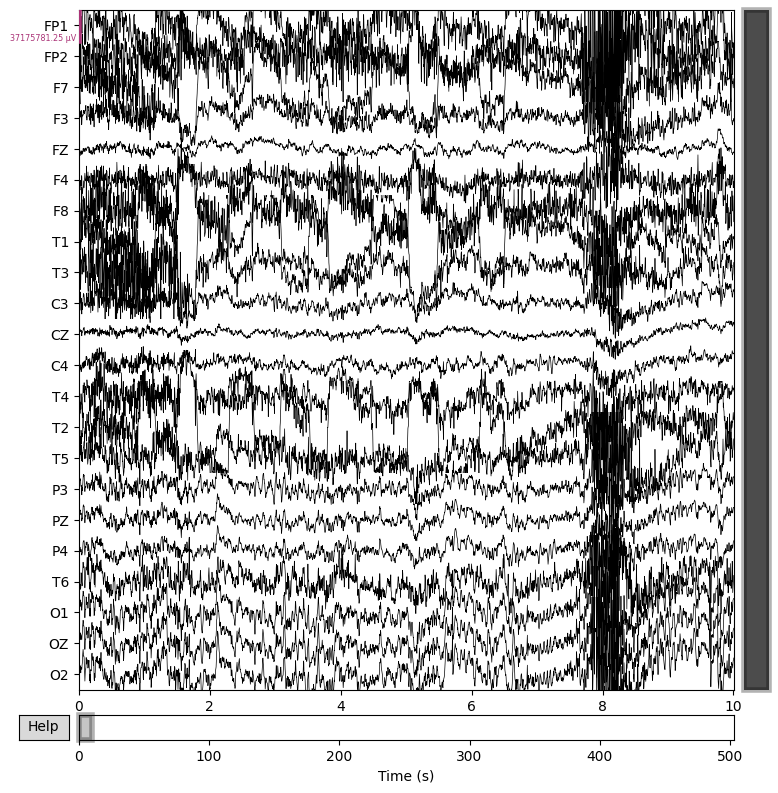

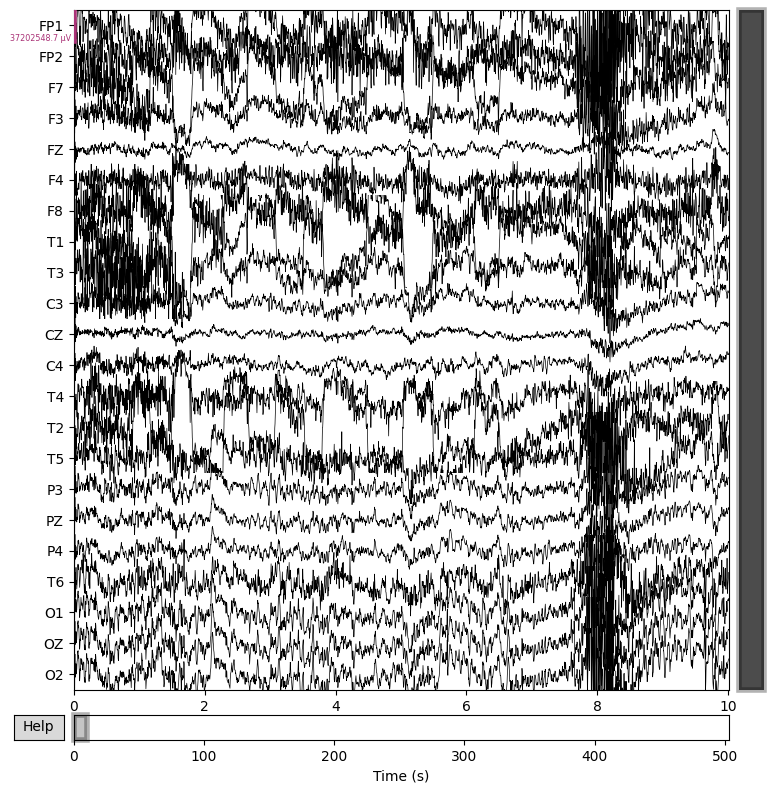

--------------
Print Data Shape after Downsamling (22, 125711)
--------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


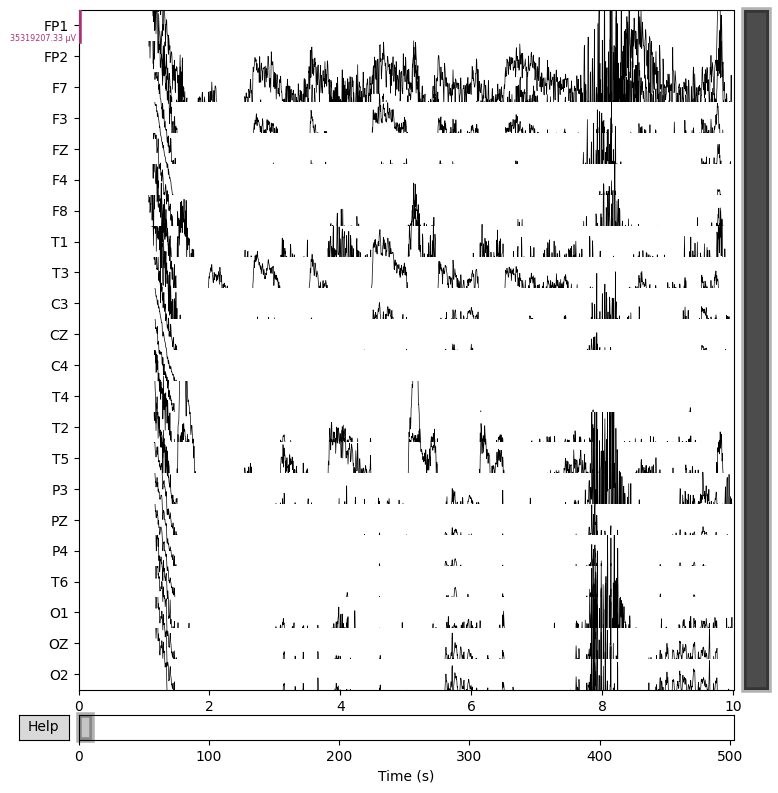

--------------
Data shape after filtering: (22, 125711)
--------------
Creating 10 batches of 32 chunks each

Processed data shapes:
Inputs: torch.Size([10, 32, 22, 500])
Attention mask: torch.Size([10, 32])
Input tensor shape: torch.Size([10, 32, 22, 500])
Embeddings shape: torch.Size([320, 1080])


In [ ]:
# Load MATLAB File with Scipy
import scipy.io as sio
import numpy as np
from scipy.io import loadmat
from torch.utils.data import Dataset
import mne
import torch
from encoder.conformer_braindecode import EEGConformer 

def split_chunks_all(data, chunk_length=500, overlap=50, num_chunks=32, max_batches=None):
    """
    Split EEG data into batches of overlapping chunks with optional limit
    """
    _, total_len = data.shape
    batch_length = chunk_length * num_chunks - overlap * (num_chunks - 1)
    stride = chunk_length - overlap

    # Calculate number of possible batches
    n_possible_batches = (total_len - batch_length) // stride + 1

    if max_batches is not None:
        n_batches = min(n_possible_batches, max_batches)
    else:
        n_batches = n_possible_batches

    print(f"Creating {n_batches} batches of {num_chunks} chunks each")

    all_batches = []
    for batch_idx in range(n_batches):
        batch_start = batch_idx * stride
        chunks = []
        chunk_start = batch_start

        for i in range(num_chunks):
            chunk = data[:, chunk_start:chunk_start + chunk_length]
            chunks.append(chunk)
            chunk_start += chunk_length - overlap

        all_batches.append(np.stack(chunks))

    return np.stack(all_batches)  # Shape: [n_batches, num_chunks, channels, chunk_length]

def preprocess_eeg_neurogpt(matlab_datapath, max_batches=None):
    # Load MATLAB file
    mat_data = sio.loadmat(matlab_datapath)

    mat_data["data"].shape
    mat_data["data_labels"][0]

    # Only keep data for the following labels (yet to add Oz, which is average of O1 and O2)
    standard_channels = [
            'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 
            'F9', 'T7', 'C3', 'Cz', 'C4', 'T8', 'F10',
            'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2'
        ]

    # Convert labels to list to use index method
    labels_list = mat_data["data_labels"][0].tolist()

    # Keep only the data for the standard channels and reorder according to standard_channels
    data = mat_data["data"][[labels_list.index(ch) for ch in standard_channels],:]

    # Between O1 and O2, create a new channel OZ, which is the average of O1 and O2
    o1_idx = mat_data["data_labels"][0].tolist().index('O1')
    o2_idx = mat_data["data_labels"][0].tolist().index('O2')

    oz = (mat_data["data"][o1_idx,:] + mat_data["data"][o2_idx,:]) / 2

    # Insert oz between o1 and o2
    data = np.insert(data, o2_idx, oz, axis=0)

    print("--------------")
    print("Data shape before processing:", data.shape)
    print("--------------")

    # Define target standard channels
    standard_channels = [
        'FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 
        'T1', 'T3', 'C3', 'CZ', 'C4', 'T4', 'T2',
        'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'OZ', 'O2'
    ]

    # Create MNE RawArray from Data
    data_mne = mne.io.RawArray(data, mne.create_info(ch_names=standard_channels, sfreq=256,ch_types='eeg'))

    # Visualize data
    data_mne.plot(n_channels=22, scalings='auto')

    # Downsample to 250Hz if needed
    if data_mne.info['sfreq'] != 250:
        data_mne.resample(250)

    # Visualize data after downsampling
    data_mne.plot(n_channels=22, scalings='auto')

    print("--------------")
    print("Print Data Shape after Downsamling", data_mne._data.shape)
    print("--------------")

    # Filter
    data_mne.filter(l_freq=.5, h_freq=100)
    data = data_mne.get_data()

    # Visualize data after filtering
    data_mne.plot(n_channels=22, scalings='auto')

    print("--------------")
    print("Data shape after filtering:", data.shape)
    print("--------------")

    # Create full data array
    full_data = np.zeros((len(standard_channels), data.shape[1]))
    for idx, ch in enumerate(standard_channels):
        if ch in data_mne.ch_names:
            ch_idx = data_mne.ch_names.index(ch)
            full_data[idx] = data[ch_idx]

    # Normalize
    full_data = (full_data - np.mean(full_data, axis=1, keepdims=True)) / (np.std(full_data, axis=1, keepdims=True) + 1e-6)

    # Get all batches of chunks
    batches = split_chunks_all(full_data, max_batches=max_batches)

    return {
    'inputs': torch.from_numpy(batches).float(),  # Shape: [n_batches, 32, 22, 500]
    'attention_mask': torch.ones(batches.shape[0], batches.shape[1], dtype=torch.long)  # Shape: [n_batches, 32]
    }

def get_neurogpt_embeddings(pretrained_path, batch, device='cpu'):
    """Get embeddings using pretrained NeuroGPT encoder"""
    encoder = EEGConformer(
       n_chans=22,
       n_times=500,
       n_filters_time=40,
       filter_time_length=25,
       pool_time_length=75,
       pool_time_stride=15,
       att_depth=6,
       att_heads=10,
       att_drop_prob=0.5,
       is_decoding_mode=False
    )

    device = torch.device(device)
    pretrained = torch.load(pretrained_path, map_location=device)
    encoder_state_dict = {k.replace('encoder.',''):v for k,v in pretrained.items() 
                        if k.startswith('encoder.')}
    encoder.load_state_dict(encoder_state_dict)
    encoder.eval()
    encoder.to(device)

    with torch.no_grad():
        x = batch['inputs'].to(device)
        print("Input tensor shape:", x.shape)

        n_batches = x.shape[0] if len(x.shape) == 4 else 1
        chunks = 32
        chann = 22
        time = 500

        x = x.reshape(-1, chann, time)  # Combine batches and chunks
        x = torch.unsqueeze(x, dim=1)  # Add channel dim for Conv2d

        x = encoder.patch_embedding(x)
        x = encoder.transformer(x)
        embeddings = x.reshape(n_batches*chunks, -1)  # [n_batches*32, 1080]

        print("Embeddings shape:", embeddings.shape)

        return embeddings

# Usage:
if __name__ == "__main__":
    matlab_datapath = "/home/kunal/UKB/Neuro_GPT/NeuroGPT_UKB/data/001_data.mat"
    processed_data = preprocess_eeg_neurogpt(matlab_datapath, max_batches=10)  # Limit to 10 batches
    print("\nProcessed data shapes:")
    print("Inputs:", processed_data['inputs'].shape)
    print("Attention mask:", processed_data['attention_mask'].shape)

    weights_path = "/home/kunal/UKB/Neuro_GPT/NeuroGPT_UKB/Neuro-GPT/pretrained_model/pytorch_model.bin"
    embeddings = get_neurogpt_embeddings(weights_path, processed_data)


In [1]:
processed_data['inputs'].shape

NameError: name 'processed_data' is not defined